In [36]:
# Imports
from ypstruct import structure
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
import re
import seaborn as sns
from scipy.sparse import lil_matrix

#### Problem representation

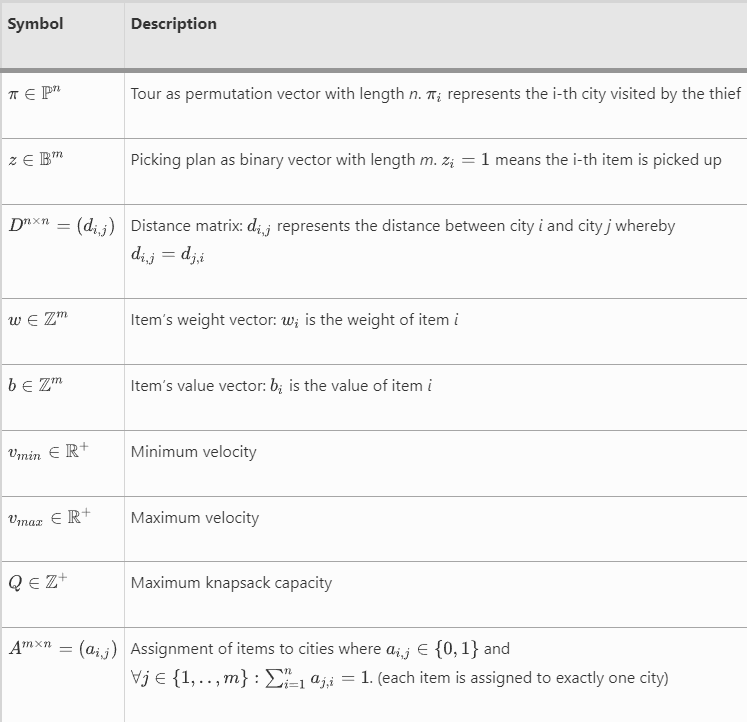

Code Example:

```python
item_values = np.array([30, 34, 40, 25]) # in order, so item 0 has a value of 30, item 1 has a value of 34, etc...
item_weights = np.array([25, 30, 40, 21]) # same as above but for weights
D = distance_matrix = np.array(
    [
    [0, 4, 9, 3],
    [4, 0, 5, 5],
    [9, 5, 0, 4],
    [3, 5, 4, 0]
    ]
)
```
For example, the following matrix says that item 0 is in city 0, item 1 in city 1, item 2 in city 2, item 3 in city 3. The rows correspond to the items and the columns to the cities.
```python
item_to_city_mapping_dict = {0: [0], 1: [1], 2: [2], 3: [3]}
```
Example candidate solution:
```python
candidate_solution = structure()
candidate_solution.tour = np.array([0, 2, 1, 3]) # 4 cities
candidate_solution.packing_plan = np.array([0, 1, 0, 1]) # 4 items
candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping, item_weights)
candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
```
Can access attributes via ```candidate_solution.tour``` and add an attribute with any name via ```candidate_solution.name = whatever```

In [ ]:
def read_TTP_instance_data(file_path):
    nb_items = int(file_path.split("-")[1].strip("n").split(".txt")[0])
    nb_cities = int(re.sub("\D", "", file_path.split("-")[0].split("/")[2]))
    # Read node coordinates from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    node_coordinates = []
    item_values = []
    item_weights= []
    in_node_section = False
    in_item_section = False
    item_to_city_mapping_dict = {}
    v_min = None
    v_max = None
    max_capacity = None
    renting_ratio = None
    item_to_city_mapping_matrix = lil_matrix((nb_items, nb_cities), dtype = int)

    for i in range(nb_cities):
        item_to_city_mapping_dict[i] = []

    # Extract node coordinates and item data
    for line in lines:
        if line.startswith("CAPACITY OF KNAPSACK"):
            max_capacity = int(line.strip().split()[3])
            continue
        elif line.startswith("MIN SPEED"):
            v_min = float(line.strip().split()[2])
        elif line.startswith("MAX SPEED"):
            v_max = float(line.strip().split()[2])
        elif line.startswith("RENTING RATIO"):
            renting_ratio = float(line.strip().split()[2])
        elif line.startswith('NODE_COORD_SECTION'):
            in_node_section = True
            in_item_section = False
            continue
        elif line.startswith('ITEMS SECTION'):
            in_node_section = False
            in_item_section = True
            continue
        elif line.startswith('EOF'):
            break
        
        if in_node_section:
            _, x, y = map(int, line.strip().split())
            node_coordinates.append((x, y))
        elif in_item_section:
            item_id, profit, weight, node_number = map(int, line.strip().split())
            item_to_city_mapping_dict[node_number - 1].append(item_id-1) # re-index to 0
            item_to_city_mapping_matrix[item_id - 1, node_number - 1] = 1
            item_values.append(profit)
            item_weights.append(weight)
    
    value_to_weight_ratio = np.array(item_values) / np.array(item_weights)
    value_to_weight_ratio_dict = {}
    for i in range(len(value_to_weight_ratio)):
        value_to_weight_ratio_dict[i] = value_to_weight_ratio[i]
    
    return {"nb_cities": nb_cities,
            "nb_items": nb_items,
            "Q": max_capacity, 
            "v_min": v_min, 
            "v_max": v_max, 
            "R": renting_ratio, 
            "pairwise_distances": pdist(node_coordinates), 
            "item_to_city_mapping_dict":item_to_city_mapping_dict,
            "item_to_city_mapping_matrix": item_to_city_mapping_matrix,
            "item_weights": np.array(item_weights),
            "item_values": np.array(item_values),
            "value_to_weight_ratio_dict": value_to_weight_ratio_dict
            }

In [37]:
def make_distance_matrix(file_path): # Kaiyuan
    distance_matrix = None
    """
    Make a distance matrix based off the data contained in the .txt files, containing data about distances between cities and
    data about the items and which city they are in.

    Parameters:
    - file_path (str): path to the file containing the data

    Returns:
    - np.ndarray: The distance matrix

    Example of distance matrix format: 
    distance_matrix = np.array(
        [
        [0, 4, 9, 3],
        [4, 0, 5, 5],
        [9, 5, 0, 4],
        [3, 5, 4, 0]
        ]
    )

    
    """
    return distance_matrix

In [38]:
def make_item_matrix(file_path): # Kaiyuan
    item_to_city_mapping_matrix = None
    """
    Make an item to city matrix based off the data contained in the .txt files, containing data about distances between cities and
    data about the items and which city they are in.

    Parameters:
    - file_path (str): path to the file containing the data

    Returns:
    - np.ndarray: The item to city mapping matrix
    
    Example of matrix format:
    item_to_city_mapping_matrix = np.array(
        [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
        ]
    )
    
    """

    return item_to_city_mapping_matrix

In [39]:
def random_tour(nb_cities):
    return random.sample(list(range(nb_cities)), k = nb_cities)

In [44]:
def pack_one(init_pop, nb_items):
    for candidate_solution in init_pop:
        packing_plan = np.zeros(nb_items)
        chosen_item = random.sample(list(range(nb_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [ ]:
def repair_packing_plan(candidate_solution, Q, item_weights):
    packing_plan = np.array(candidate_solution.packing_plan)
    selected_items = list(np.nonzero(packing_plan))
    selected_items_weights = item_weights[selected_items]
    while np.sum(selected_items_weights) > Q:
        candidate_solution.packing_plan[random.sample(list(selected_items[0]), k = 1)[0]] = 0
        packing_plan = np.array(candidate_solution.packing_plan)
        selected_items = list(np.nonzero(packing_plan))
        selected_items_weights = item_weights[selected_items]

In [45]:
def pack_random(init_pop, Q, item_weights):
    nb_items = len(item_weights)
    for candidate_solution in init_pop:
        packing_plan = [random.choice(list(range(2))) for _ in range(nb_items)]
        candidate_solution.packing_plan = packing_plan
        repair_packing_plan(candidate_solution, Q, item_weights)
    return init_pop

In [47]:
def generate_initial_population(pop_size, nb_cities, pack_init_method, tour_init_method = "random", Q = None, value_to_weight_ratio_dict = None, item_weights = None): # Jack

    init_pop = []
    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(nb_cities)
            init_pop.append(candidate_solution)

    if pack_init_method == "pack_random":
        pack_random(init_pop, Q, item_weights)
    elif pack_init_method == "pack_one":
        pack_one(init_pop, len(item_weights))

    return init_pop

Cost function for the knapsack, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [92]:
def knapsack_cost(candidate_solution, item_values):
    
    """
    Calculate the total cost of a candidate solution in a knapsack problem.

    Parameters:
    - candidate_solution (numpy.ndarray): A candidate_solution represented as a structure from the ypstruct library with a 
    knapsack attribute, tour attribute, knapsack_cost attribute and tour_cost attribute.
    - item_values (numpy.ndarray): An array of values corresponding to each item
      in the knapsack. The first value corresponds to the value of the first item, the second corresponds to the value for the second, 
      etc...

    Returns:
    - float: The total cost of the candidate solution, computed as the sum of
      selected item values in the knapsack.
    """
    return np.sum(np.array(candidate_solution.packing_plan) * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the distance matrix $d$ and $a$ is the item mapping matrix and R is the renting ratio

In [ ]:
def get_pdist_distance(pairwise_distances, i, j, nb_cities):
     if i < j:
        return pairwise_distances[nb_cities * i + j - ((i + 2) * (i + 1)) // 2]
     elif i > j:
        return pairwise_distances[nb_cities * j + i - ((j + 2) * (j + 1)) // 2]

In [88]:
def tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_matrix, item_weights, vmax, vmin, Q, renting_ratio):
    tour = candidate_solution.tour
    nb_cities = len(tour)
    # calculate the weight picked up at each city
    weight_at_city_i = [
        sum(item_to_city_mapping_matrix.getcol(city).toarray().flatten() * np.array(candidate_solution.packing_plan) * item_weights) for city in tour
        ]
        
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.cumsum(weight_at_city_i)
    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)
    # retrieve the distance between the cities 
    distance_between_cities = []


    distance_between_cities = [get_pdist_distance(pairwise_distances, tour[i], tour[i+1], nb_cities) for i in range(0, len(tour) - 1)]
    distance_between_cities.append(get_pdist_distance(pairwise_distances, tour[0], tour[-1], nb_cities))
    distance_between_cities = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

In [82]:
def evaluate_candidate_solution_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_matrix, item_weights, item_values, vmax, vmin, Q, renting_ratio):
    candidate_solution.tour_cost = tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_matrix, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

Each individual gets a rank based on its level of domination

 Then both the populations are combined and classified using non-dominated sorting. After the completion of non-dominated sorting, filling of new population starts with the assignment of rank 1 for the best non-dominated front. This continues for successive fronts with the assignment of ranks.

  The fast sort algorithm [3] is described as below for each.

• for each individual p in main population P do the following

    – Initialize Sp = ∅. This set would contain all the individuals that is
    being dominated by p.

    – Initialize np = 0. This would be the number of individuals that dominate p.

    – for each individual q in P

        ∗ if p dominated q then

            · add q to the set Sp i.e. Sp = Sp ∪ {q}

        ∗ else if q dominates p then

            · increment the domination counter for p i.e. np = np + 1

    – if np = 0 i.e. no individuals dominate p then p belongs to the first
      front; Set rank of individual p to one i.e prank = 1. Update the first
      front set by adding p to front one i.e F1 = F1 ∪ {p}

• This is carried out for all the individuals in main population P.

• Initialize the front counter to one. i = 1

• following is carried out while the i
th front is nonempty i.e. Fi 6= ∅

    – Q = ∅. The set for storing the individuals for (i + 1)th front.

    – for each individual p in front Fi

        ∗ for each individual q in Sp (Sp is the set of individuals dominated
        by p)

            · nq = nq −1, decrement the domination count for individual
            q.

            · if nq = 0 then none of the individuals in the subsequent
            fronts would dominate q. Hence set qrank = i + 1. Update
            the set Q with individual q i.e. Q = Q ∪ q.

    – Increment the front counter by one.
    
    – Now the set Q is the next front and hence Fi = Q.

    https://web.njit.edu/~horacio/Math451H/download/Seshadri_NSGA-II.pdf

In [24]:
def get_ranks(population): # Ursula
    #Current front set
    f = []
    #Sets for the entire population
    big_s = []
    #dominant individuals for the entire population
    big_np = []
    for p in population:
        #S is the set of individuals that are dominated by p
        s = []
        #np = the number of individuals that dominate p
        np = 0
        #checking for dominiance
        for q in population:
            if q.packing_plan_cost < p.packing_plan_cost and q.tour_cost >= p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost <= p.packing_plan_cost and q.tour_cost > p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost > p.packing_plan_cost and q.tour_cost <= p.tour_cost:
                np +=1
            elif q.packing_plan_cost >= p.packing_plan_cost and q.tour_cost < p.tour_cost:
                np +=1
        if np == 0:
            p.rank = 1
            f.append(p)
        #adding domininating sets and dominant individuals to a central list
        big_s.append(s)
        big_np.append(np)
    front_counter = 1
    #calculating the front for each of the candidate solutions
    while len(f) != 0:
        #individuals from the i+1 front
        q = []
        for y in f:
            for x in big_s[population.index(y)]:
                big_np[population.index(x)] -= 1
                if big_np[population.index(x)] == 0:
                    x.rank = front_counter+1
                    q.append(x)
        front_counter += 1
        f = q
    return None

The crowding distance is used as a density estimation in the objective space.

For each front Fi, n is the number of individuals.

– initialize the distance to be zero for all the individuals i.e. Fi(dj ) = 0,
where j corresponds to the jth individual in front Fi.

– for each objective function m

    ∗ Sort the individuals in front Fi based on objective m i.e. I = sort(Fi, m)

    ∗ Assign infinite distance to boundary values for each individual in Fi

    i.e. I(d1) = ∞ and I(dn) = ∞

    ∗ for k = 2 to (n − 1)

        · I(d_k) = I(dk) + I(k + 1).m − I(k − 1).m/fmaxm − fminm
        
        · I(k).m is the value of the mth objective function of the kth individual in I


https://www.sciencedirect.com/topics/computer-science/crowding-distance

$$
    I(d_k) = I(d_k) + \frac{I(k+1)_m - I(k-1)_m}{f^{max}_m, f^{min}_m}    
$$

In [32]:
def get_crowding_distance(population): # Ursula
    
    ranks = []
    for p in population:
        ranks.append(p.rank)
    max_rank = max(ranks)
    dist = []
    fronts = []
    for i in range(1, max_rank):
        front = []
        for q in population:
            if q.rank == i:
                front.append(q)
        fronts.append(front)
            
   # for j in (tour_cost, packing_plan_cost):
       # sorted(front, key=lambda x: x.tour_cost
    print(fronts)
    
    
    
    
    
  
    """sorted(front, key=lambda x: x.tour_cost)
            front[0].crowding_distance = float('inf')
            front[-1].crowding_distance = float('inf')
            
            for j in range(1,(len(front)-1)):
                dist = dist + 
                    
    """
                
    return None

In [ ]:
get_crowding_distance()

In [6]:
def tournament_selection(population): # Swaroop
    
    """
    Performs NSGA-II style tournament selection.

    Parameters:
    - population (list): list of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    
    Randomly select 2 candidate solutions from the population (without replacement) compare first their rank (return) the one with the lowest 
    rank. If they have the same rank, return solution with greater crowding distance.

    Return: 
    ypstruct.Struct: candidate solution represented in the same way as the candidate solutions in the population
    """
    # Randomly select 2 candidate solutions from the population (without replacement)
    candidates = random.sample(population, k=2)
    
    # Compare their ranks
    if candidates[0].rank < candidates[1].rank:
        return candidates[0]  # Return the solution with lower rank
    elif candidates[0].rank > candidates[1].rank:
        return candidates[1]  # Return the solution with lower rank
    else:  # If ranks are equal, choose the one with greater crowding distance
        if candidates[0].crowding_distance > candidates[1].crowding_distance:
            return candidates[0]  # Return the solution with greater crowding distance
        else:
            return candidates[1]  # Return the solution with greater crowding distance
        

In [55]:
def OX1_tour_crossover(parent1, parent2): # Kanchan

    """
    Implement single-point ordered crossover (OX1 Crossover) on the tours of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.Struct): same as parent1

    Perform single-point ordered crossover on the tours contained in the parent structures.

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.


    """
    
    pass

In [56]:
def packing_plan_crossover(parent1, parent2, crossover_type): # Jack

    """
    Implement single point or two point crossover on the packing plans of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.Struct): same as parent1
    - crossover_type (str): defines the crossover type to be used. Can be either "single_point" or "two_point".

    Implement single point or two point crossover on the packing plans of the parents selected by tournament selection in order to 
    produce the children.

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over packing plans.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over placking plans.


    """
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    child1_packing_plan = np.array(child1.packing_plan)
    child2_packing_plan = np.array(child2.packing_plan)


    if crossover_type == "single_point":
        crossover_point = random.sample(range(len(parent1.packing_plan)), k = 1)[0]
        child1.packing_plan[0:crossover_point] = child2.packing_plan[0:crossover_point]
        child2.packing_plan[0:crossover_point] = child1.packing_plan[0:crossover_point]

    elif crossover_type == "two_point":
        crossover_points = random.sample(range(len(parent1.packing_plan)), k = 2)
        crossover_points = sorted(crossover_points)
        first_cross_point = crossover_points[0]
        second_cross_point = crossover_points[1]     
        child1.packing_plan[first_cross_point:second_cross_point] = child2_packing_plan[first_cross_point:second_cross_point]
        child2.packing_plan[first_cross_point:second_cross_point] = child1_packing_plan[first_cross_point:second_cross_point]

    return child1, child2




In [57]:
def derive_tour_from_packing_plan(candidate_solution, item_to_city_mapping_dict, item_weights): # Jack
    weight_at_city_i = [
            sum(np.array(candidate_solution.packing_plan)[item_to_city_mapping_dict[city]] * item_weights[item_to_city_mapping_dict[city]]) for city in candidate_solution.tour
        ]
    weight_at_city_i_dict = dict(zip(candidate_solution.tour, weight_at_city_i))
    sorted_weight_at_city_i_dict = dict(sorted(weight_at_city_i_dict.items(), key=lambda x:x[1], reverse = False))
    return list(sorted_weight_at_city_i_dict)

In [59]:
def tour_mutation(child1, child2, mutation_type): # Kaiyuan
    
    """
    Implement single swap mutation or inversion mutation on the tours of the children.

    Parameters:
    - child1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.Struct): same as parent1
    - mutation_type (str): defines the mutation type to be used. Can be either "single_swap" or "inversion".

    Implement single swap mutation or inversion mutation on the tours of the children produced by the crossover operation.

    Return:
    ypstruct.Struct: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.
    ypstruct.Struct: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.


    """
    
    pass

In [60]:
def packing_plan_mutation(child1, child2, mutation_percentage): # Nafees

    """
    Implement bit flip mutation on the packing plans of the children.

    Parameters:
    - child1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.Struct): same as parent1
    - mutation_percentage (float): defines the percentage of bits to be flipped

    Implement bit flip mutation on the packing plans of the children produced by the crossover operation. Can define the percentage of bits
    to be flipped

    Return:
    ypstruct.Struct: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.
    ypstruct.Struct: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.


    """

    pass

In [62]:
def replacement(population): #
    pass

In [ ]:
def get_pareto_front(population):
    pass # return all solutions of rank 1

In [63]:
def get_best_solutions(population, n_solutions): # Nafees
    pass # return n_solutions best solutions (first n_solutions of population which is first ordered by rank and then by crowding distance)

In [ ]:
def TTP_solver(file_path, n_solutions, pop_size, child_pop_size, pack_init_method, tour_init_method, max_iter, tour_crossover_type, packing_plan_crossover_type, mutation_type, mutation_percentage):
    ttp_instance = read_TTP_instance_data(file_path)
    nb_cities = ttp_instance["nb_cities"]
    nb_items = ttp_instance["nb_items"]
    Q = ttp_instance["Q"]
    vmin = ttp_instance["v_min"]
    vmax = ttp_instance["v_max"]
    R = ttp_instance["R"]
    pairwise_distances = ttp_instance["pairwise_distances"]
    item_to_city_mapping_dict = ttp_instance["item_to_city_mapping_dict"]
    item_weights = ttp_instance["item_weights"]
    item_values = ttp_instance["item_values"]
    value_to_weight_ratio_dict = ttp_instance["value_to_weight_ratio_dict"]

    # generate initial population
    population = generate_initial_population(pop_size, nb_cities, pack_init_method, tour_init_method, Q, value_to_weight_ratio_dict, item_weights)
    
    # evaluate initial population
    for candidate_solution in population:
        evaluate_candidate_solution_cost_pdist(candidate_solution,
                                     pairwise_distances,
                                     item_to_city_mapping_dict,
                                     item_weights,
                                     item_values,
                                     vmax,
                                     vmin,
                                     Q,
                                     R)
    
    # get the ranks of the initial population
    get_ranks(population)
    # get the crowding distances of the initial populationo
    get_crowding_distance(population)

    for _ in range(max_iter):
        # generate pop_size number of children solutions
        for _ in range(int(child_pop_size / 2)):

            # perform tournament selection to select the parents
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            
            # perform the crossover operation on the parents
            # if packing plan crossover type is none either perform single point order crossover (OX1 crossover) or no crossover on the tour
            # if packing plan crossover is not none, randomly choose between performing a crossover on the tour or the packing plan
            if tour_crossover_type == "OX1" and packing_plan_crossover_type is None:
                child1, child2 = OX1_tour_crossover(parent1, parent2)
            elif tour_crossover_type is None and packing_plan_crossover_type is None:
                continue
            elif tour_crossover_type == "OX1" and packing_plan_crossover_type is not None:
                x = np.random.random(1)
                if x >= 0.5:
                    child1, child2 = OX1_tour_crossover(parent1, parent2)
                elif x < 0.5:
                    if packing_plan_crossover_type == "single_point":
                        child1, child2 = packing_plan_crossover(parent1, parent2, packing_plan_crossover_type)

                    elif packing_plan_crossover_type == "two_point":
                        child1, child2 = packing_plan_crossover(parent1, parent2, packing_plan_crossover_type)

            # choose randomly between mutating the tour and the packing plan
            x = np.random.random(1)
            if x >= 0.5:
                child1, child2 = tour_mutation(child1, child2, mutation_type)
            if x < 0.5:
                child1, child2 = packing_plan_mutation(child1, child2, mutation_percentage)
                # repair the packing plan
                repair_packing_plan(child1, Q, item_weights)
                repair_packing_plan(2, Q, item_weights)
                derive_tour_from_packing_plan(child1, item_to_city_mapping_dict, item_weights)
                derive_tour_from_packing_plan(child2, item_to_city_mapping_dict, item_weights)

            # evaluate the fitness of the children
            evaluate_candidate_solution_cost_pdist(child1,
                                     pairwise_distances,
                                     item_to_city_mapping_dict,
                                     item_weights,
                                     item_values,
                                     vmax,
                                     vmin,
                                     Q,
                                     R)
            evaluate_candidate_solution_cost_pdist(child2,
                                     pairwise_distances,
                                     item_to_city_mapping_dict,
                                     item_weights,
                                     item_values,
                                     vmax,
                                     vmin,
                                     Q,
                                     R)
            
            # inject the children into the new population
            population.append(child1)
            population.append(child2)

        # update the ranks
        get_ranks(population)
        # update the crowding distances
        get_crowding_distance(population)
        
        # update the population
        replacement(population)
    
    return get_pareto_front(population), get_best_solutions(population, n_solutions)    

            




### Not Actually Sure If Need to Do Next Part
I think they might have reference points and then calculate the hypervolumes themselves. Can use hypervolume for optimisation purposes though

Get Nadir Point and Estimated Ideal to Calculate volumne. Can use hypervolume to define what set of parameters are better than another set. The bigger the hypervolume, the better.

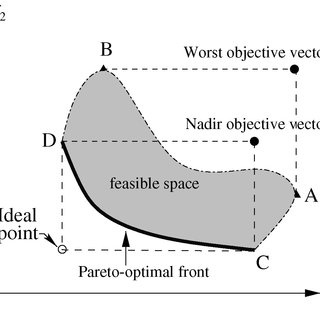 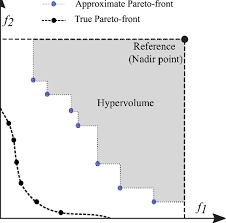

In [64]:
def get_nadir_point():
    pass

In [65]:
def get_ideal_point():
    pass

In [66]:
def get_hyper_volume(pareto_front): # Just an example of how to do it.
    reference_point = (max(pareto_front, key=lambda x: x[0])[0] + 1, max(pareto_front, key=lambda x: x[1])[1] + 1) # nadir point
    sorted_pareto_front = sorted(pareto_front, key=lambda x: x[0])

    hypervolume = 0
    for i in range(len(sorted_pareto_front) - 1):
        x, y = sorted_pareto_front[i]
        x_next, y_next = sorted_pareto_front[i + 1]
        hypervolume += (x_next - x) * (y_next - y)

    return hypervolume
